# Emotion Detection Using Speech 


# Business Summary 

# Import Libraries 

In [56]:


import pandas as pd 
import numpy as np
import math
import os
from scipy import signal 
import matplotlib.pyplot as plt
import seaborn as sns
import librosa 
import librosa.display 

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.random import set_seed
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ReduceLROnPlateau

# EDA 

The RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) is a widely used dataset for emotion classification using recorded speech because of its high quality and consistent audio quality.


RAVDESS does not come with any sort of metadata table with information on the recordings but instead the filename themselves have all the information. Each filename has a 7 part numerical identifier (ex. 03-01-04-01-01-02-12.wav). The identifiers represent the following: 

    1.) Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    2.) Vocal channel (01 = speech, 02 = song).
    3.) Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    4.) Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
    5.) Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
    6.) Repetition (01 = 1st repetition, 02 = 2nd repetition).
    7.) Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So for example the file 03-01-04-01-01-02-12.wav contains the following metadata: 

    1.) Audio-only (03)
    2.) Speech (01)
    3.) Sad (04)
    4.) Normal Intensity (01)
    5.) "Kids are talking by the door" (01)
    6.) Second Repetition (02)
    7.) Actor-12 Male (12) 

In [57]:
Ravdess = '/Users/stephen/Emotion_Detection-/data/RAVDESS/'

ravdess_directory_list = os.listdir(Ravdess)
ravdess_directory_list.sort

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,angry,/Users/stephen/Emotion_Detection-/data/RAVDESS...
1,fear,/Users/stephen/Emotion_Detection-/data/RAVDESS...
2,fear,/Users/stephen/Emotion_Detection-/data/RAVDESS...
3,angry,/Users/stephen/Emotion_Detection-/data/RAVDESS...
4,disgust,/Users/stephen/Emotion_Detection-/data/RAVDESS...


/Users/stephen/opt/anaconda3/envs/torch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


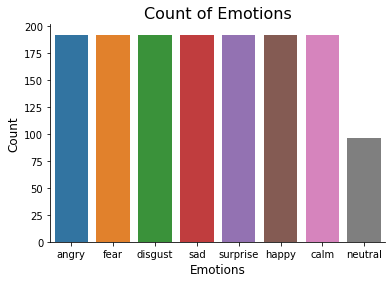

In [58]:
plt.title('Count of Emotions', size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Data Augmentation 
creating synthetic data 



In [59]:
# adding Additive White Gausian Noise
def noise(data, SNR=10):   # https://medium.com/analytics-vidhya/adding-noise-to-audio-clips-5d8cee24ccb8
    # RMS value of signal 
    RMS_s = math.sqrt(np.mean(data**2))
    # RMS values of noise 
    RMS_n = math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    # using population formula for standard daviation 

    STD_n = RMS_n 
    noise = np.random.normal(0, STD_n, data.shape[0])
    new_data = data + noise
    return new_data

# Time Strectching 
def stretch(data, rate=0.90):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-2, high = 3)*1000)
    return np.roll(data, shift_range)

# Pre Emphasis     info on Pre-Emphasis in speech recognition: https://wiki.aalto.fi/display/ITSP/Pre-emphasis
def pre_emphasize(data):
    return librosa.effects.preemphasis(data, coef=1)

def pitch(data, sampling_rate):
    return librosa.effects.pitch_shift(data, sampling_rate, n_steps=1, bins_per_octave=24)

# Extracting Audio Data Features 

# Baseline Model 

In [60]:
def mel_features(path): 
    result = np.array([])
     
    mel = np.mean(librosa.feature.melspectrogram(y=path, sr=16000).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result


def get_mel_features(path): 
    # duration and offset are used to take care of the no audio in start and the ending of each audio files .
    _data, sample_rate = librosa.load(path, sr=16000, duration=2.5, offset=0.6) 
    # apply High Pass filter to attenuate all signals below 80 hz
    sos = signal.butter(4, 80, 'hp', fs=1000, output='sos') # butterworth filter 
    data = signal.sosfilt(sos, _data)


    # without augmentation
    res1 = mel_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = mel_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = mel_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    pre_emp_data = pre_emphasize(data)
    res4 = mel_features(pre_emp_data)
    result = np.vstack((result, res4)) # stacking vertically
    
    return result


In [61]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_mel_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 4 times as we have made 4 augmentation techniques on each audio file.
        Y.append(emotion)

In [62]:
len(X), len(Y), Ravdess_df.Path.shape

(5760, 5760, (1440,))

In [63]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,labels
0,6.164128e-14,6.467168e-14,9.365516e-14,2.751639e-13,1.373921e-12,1.474758e-10,3.422967e-09,1.843225e-08,3.115034e-07,8.323617e-07,...,0.007071,0.011748,0.011426,0.010883,0.006832,0.004739,0.003541,0.000767,0.000079,angry
1,1.369259e-03,1.611664e-03,1.616773e-03,1.795063e-03,1.591095e-03,1.746002e-03,1.484136e-03,1.942515e-03,2.011458e-03,2.019620e-03,...,0.008566,0.013377,0.013018,0.012499,0.008188,0.006304,0.005351,0.002465,0.001743,angry
2,1.178604e-10,1.039265e-10,1.455528e-10,1.033174e-10,1.240323e-10,1.216049e-10,2.604228e-10,1.444700e-09,3.345894e-08,1.548455e-07,...,0.000899,0.001422,0.002639,0.002793,0.002877,0.001478,0.000618,0.000194,0.000003,angry
3,1.722043e-12,1.725052e-12,1.730277e-12,1.737284e-12,1.749920e-12,2.304626e-12,1.729200e-11,1.135216e-10,2.349300e-09,6.907684e-09,...,0.025747,0.043559,0.043036,0.041581,0.026425,0.018571,0.013968,0.003045,0.000315,angry
4,2.379134e-12,2.385174e-12,2.407262e-12,2.489640e-12,3.177041e-12,5.186895e-11,1.157138e-09,2.065697e-08,1.564348e-07,5.026606e-07,...,0.001535,0.001610,0.001820,0.001444,0.001527,0.002631,0.002630,0.000628,0.000026,fear


In [64]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [65]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [66]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 128), (4320, 8), (1440, 128), (1440, 8))

In [67]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 128), (4320, 8), (1440, 128), (1440, 8))

In [68]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 128, 1), (4320, 8), (1440, 128, 1), (1440, 8))

In [69]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 64, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 32, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 32, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 16, 128)          0

2021-12-05 20:30:59.039010: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [70]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
68/68 [==============================] - 6s 81ms/step - loss: 2.0145 - accuracy: 0.1884 - val_loss: 1.9518 - val_accuracy: 0.2090 - lr: 0.0010
Epoch 2/50
68/68 [==============================] - 5s 75ms/step - loss: 1.9370 - accuracy: 0.2220 - val_loss: 1.8885 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 3/50
68/68 [==============================] - 5s 74ms/step - loss: 1.8990 - accuracy: 0.2403 - val_loss: 1.9046 - val_accuracy: 0.2285 - lr: 0.0010
Epoch 4/50
68/68 [==============================] - 5s 72ms/step - loss: 1.8671 - accuracy: 0.2465 - val_loss: 1.9302 - val_accuracy: 0.2375 - lr: 0.0010
Epoch 5/50
68/68 [==============================] - 5s 78ms/step - loss: 1.8703 - accuracy: 0.2495 - val_loss: 1.8295 - val_accuracy: 0.2625 - lr: 0.0010
Epoch 6/50
68/68 [==============================] - 6s 89ms/step - loss: 1.8453 - accuracy: 0.2623 - val_loss: 1.8010 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 7/50
68/68 [==============================] - 5s 75ms/step - loss: 1.8

In [71]:
y_test.shape

(1440, 8)

45/45 [==============================] - 1s 11ms/step - loss: 1.6845 - accuracy: 0.3306
Accuracy of our model on test data :  33.05555582046509 %


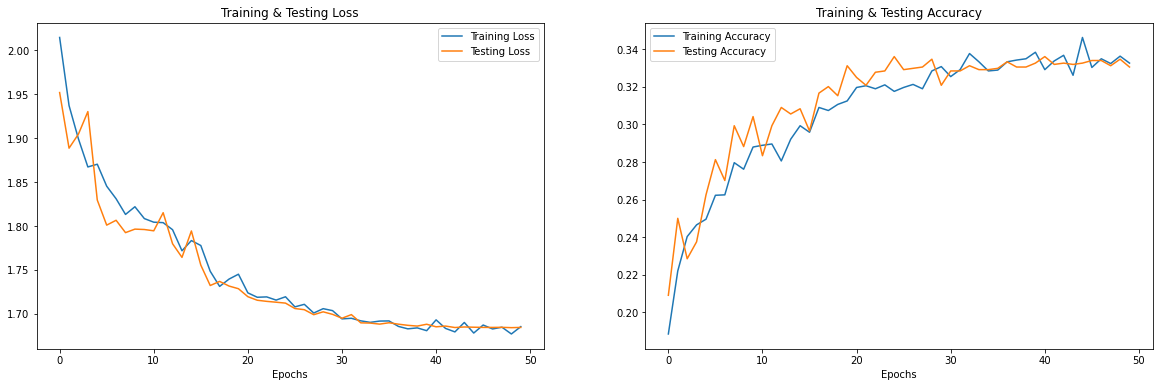

<Figure size 432x288 with 0 Axes>

In [72]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()
plt.savefig('Model Results')

# Model with more feature extractions 


In [74]:
x_train

array([[[-0.14016697],
        [-0.14099848],
        [-0.1379908 ],
        ...,
        [-0.27846762],
        [-0.19627316],
        [-0.14299119]],

       [[-0.14016697],
        [-0.14099848],
        [-0.1379908 ],
        ...,
        [-0.27925086],
        [-0.19656686],
        [-0.14299714]],

       [[-0.14016697],
        [-0.14099848],
        [-0.1379908 ],
        ...,
        [-0.27905805],
        [-0.19649464],
        [-0.14300034]],

       ...,

       [[-0.12147053],
        [-0.12271017],
        [-0.1238924 ],
        ...,
        [-0.16987686],
        [-0.12545545],
        [-0.12076216]],

       [[-0.14016696],
        [-0.14099847],
        [-0.13799079],
        ...,
        [-0.22043991],
        [-0.18136492],
        [-0.14193496]],

       [[-0.14016697],
        [-0.14099848],
        [-0.1379908 ],
        ...,
        [-0.24185868],
        [-0.18013976],
        [-0.14231431]]])

In [75]:
%reset